In [23]:
!git clone https://github.com/mirna-k/dcp-miniBRANCH.git
%cd dcp-miniBRANCH

Cloning into 'dcp-miniBRANCH'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 35 (delta 8), reused 7 (delta 5), pack-reused 16 (from 1)
Receiving objects: 100% (35/35), 35.84 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (9/9), done.
/content/dcp-miniBRANCH/dcp-miniBRANCH/dcp-miniBRANCH


In [24]:
!pip install open3d scipy

In [25]:
!pip install open3d

In [26]:
from google.colab import files
uploaded = files.upload()

Saving miniBRANCH-20250531T152505Z-1-001.zip to miniBRANCH-20250531T152505Z-1-001.zip


In [27]:
import zipfile

zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("miniBRANCH_data")

!ls miniBRANCH_data/miniBRANCH

tree_1_V_0001  tree_1_V_0009  tree_1_V_0011  tree_1_V_0012


In [28]:
from data import miniBRANCH

test_dataset = miniBRANCH(
    rgb_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/color',
    depth_dir='miniBRANCH_data/miniBRANCH/tree_1_V_0001/Filtered__noGrass/depth',
    num_points=1024,
    partition='test'
)

In [29]:
from model import DCP
import torch

class Args:
    emb_dims = 512
    emb_nn = 'pointnet'
    pointer = 'transformer'
    head = 'svd'
    n_blocks = 1
    n_heads = 4
    ff_dims = 1024
    dropout = 0.0
    cycle = False

args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DCP(args).to(device)

model.load_state_dict(torch.load('rezultati_treniranja.pth', map_location=device))
model.eval()

DCP(
  (emb_nn): PointNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (conv5): Conv1d(128, 512, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pointer): Transformer(
    (model): EncoderDecoder(
      (encoder): Encoder(
        (layers): ModuleList(
          (0): EncoderLayer(
            (se

In [30]:
sample = test_dataset[0]
src, tgt = sample[0], sample[1]
src_tensor = torch.tensor(src, dtype=torch.float32).unsqueeze(0).to(device)
tgt_tensor = torch.tensor(tgt, dtype=torch.float32).unsqueeze(0).to(device)


In [31]:
with torch.no_grad():
    R_pred, t_pred, _, _ = model(src_tensor, tgt_tensor)
    src_pred = torch.matmul(R_pred, src_tensor) + t_pred.unsqueeze(-1)

src_pred_np = src_pred.squeeze(0).cpu().numpy().T
tgt_np = tgt_tensor.squeeze(0).cpu().numpy().T

In [33]:
# Prikaz izvornih (ground truth) point cloudova za prvih 5 uzoraka iz testnog skupa
import plotly.graph_objects as go
for i in range(5):
    points = test_dataset[i][0].T
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(size=2, color=points[:,2], colorscale='Viridis', opacity=0.8)
    )])
    fig.update_layout(title=f'Uzorak #{i}', width=700)
    fig.show()


In [34]:
# Prikaz predikcije (transformiranog point clouda) modela za prvih 5 uzoraka iz testnog skupa
import plotly.graph_objects as go
import torch

for i in range(5):
    sample = test_dataset[i]
    src = sample[0]
    src_tensor = torch.tensor(src, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        tgt_tensor = torch.tensor(sample[1], dtype=torch.float32).unsqueeze(0).to(device)
        R_pred, t_pred, _, _ = model(src_tensor, tgt_tensor)
        src_pred = torch.matmul(R_pred, src_tensor) + t_pred.unsqueeze(-1)

    src_pred_np = src_pred.squeeze(0).cpu().numpy().T

    fig = go.Figure(data=[go.Scatter3d(
        x=src_pred_np[:, 0],
        y=src_pred_np[:, 1],
        z=src_pred_np[:, 2],
        mode='markers',
        marker=dict(size=2, color=src_pred_np[:,2], colorscale='Viridis', opacity=0.8)
    )])
    fig.update_layout(title=f'Predikcija modela, uzorak #{i}', width=700)
    fig.show()


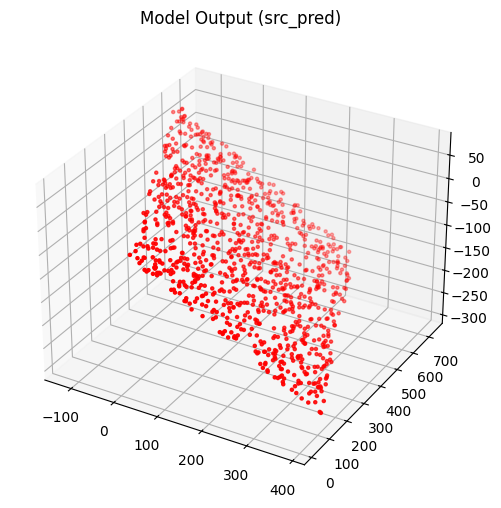

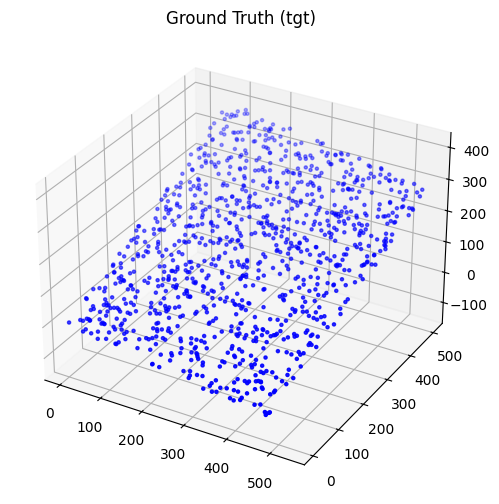

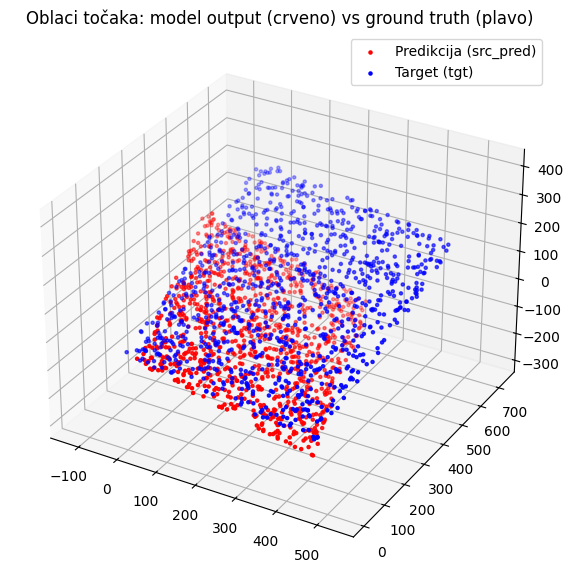

In [35]:
import matplotlib.pyplot as plt

def plot_point_cloud(points, title="Point cloud", color='b'):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], s=5, c=color)
    ax.set_title(title)
    plt.show()

plot_point_cloud(src_pred_np, title='Model Output (src_pred)', color='r')
plot_point_cloud(tgt_np, title='Ground Truth (tgt)', color='b')

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(src_pred_np[:,0], src_pred_np[:,1], src_pred_np[:,2], s=5, c='r', label='Predikcija (src_pred)')
ax.scatter(tgt_np[:,0], tgt_np[:,1], tgt_np[:,2], s=5, c='b', label='Target (tgt)')
ax.set_title('Oblaci točaka: model output (crveno) vs ground truth (plavo)')
ax.legend()
plt.show()


In [36]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=src_pred_np[:, 0], y=src_pred_np[:, 1], z=src_pred_np[:, 2],
    mode='markers',
    marker=dict(size=3, color='red', opacity=0.7),
    name='Predikcija (src_pred)'
))

fig.add_trace(go.Scatter3d(
    x=tgt_np[:, 0], y=tgt_np[:, 1], z=tgt_np[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name='Ground Truth (tgt)'
))

fig.update_layout(
    title="3D Point Cloud - Interaktivni prikaz",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(x=0.01, y=0.99),
    width=700,
    margin=dict(r=10, l=10, b=10, t=30)
)

fig.show()

In [37]:
# Ispis dimenzija i raspona koordinata point cloudova
print("src_pred_np shape:", src_pred_np.shape)
print("Prvih 5 točaka src_pred_np:\n", src_pred_np[:5])
print("X min/max src_pred_np:", src_pred_np[:,0].min(), src_pred_np[:,0].max())
print("Y min/max src_pred_np:", src_pred_np[:,1].min(), src_pred_np[:,1].max())
print("Z min/max src_pred_np:", src_pred_np[:,2].min(), src_pred_np[:,2].max())

print("tgt_np shape:", tgt_np.shape)
print("Prvih 5 točaka tgt_np:\n", tgt_np[:5])
print("X min/max tgt_np:", tgt_np[:,0].min(), tgt_np[:,0].max())
print("Y min/max tgt_np:", tgt_np[:,1].min(), tgt_np[:,1].max())
print("Z min/max tgt_np:", tgt_np[:,2].min(), tgt_np[:,2].max())


src_pred_np shape: (1024, 3)
Prvih 5 točaka src_pred_np:
 [[ 206.58716   138.11095  -158.31885 ]
 [ 355.87704   213.39212  -271.32684 ]
 [ 216.34738    97.6343   -163.92053 ]
 [ 222.38754   646.62024  -189.65744 ]
 [   7.328264  186.65854   -11.374852]]
X min/max src_pred_np: -124.80096 388.13953
Y min/max src_pred_np: 13.597458 734.0337
Z min/max src_pred_np: -292.64215 71.045135
tgt_np shape: (1024, 3)
Prvih 5 točaka tgt_np:
 [[109.881325  432.45438   374.3199   ]
 [340.39792   130.72733    -2.7475963]
 [ 79.50338   102.43804    69.486496 ]
 [271.23584   167.47638    58.82443  ]
 [129.05309   369.79593   306.9451   ]]
X min/max tgt_np: 1.7722946 538.90045
Y min/max tgt_np: 3.3951325 504.62457
Z min/max tgt_np: -130.70685 407.34427


In [39]:
# Chamfer distance
import numpy as np
from scipy.spatial import cKDTree

def chamfer_distance(a, b):
    tree_a = cKDTree(a)
    tree_b = cKDTree(b)
    dist_ab, _ = tree_a.query(b)
    dist_ba, _ = tree_b.query(a)
    return np.mean(dist_ab**2) + np.mean(dist_ba**2)

cd = chamfer_distance(src_pred_np, tgt_np)
print(f'Chamfer distance između predikcije i ground truth: {cd:.6f}')


Chamfer distance između predikcije i ground truth: 199790.562696


In [40]:
# Hausdorff distance
from scipy.spatial.distance import cdist
def hausdorff_distance(a, b):
    dists = cdist(a, b)
    return max(dists.min(axis=1).max(), dists.min(axis=0).max())
hd = hausdorff_distance(src_pred_np, tgt_np)
print(f'Hausdorff distance između predikcije i ground truth: {hd:.4f}')

Hausdorff distance između predikcije i ground truth: 567.3045


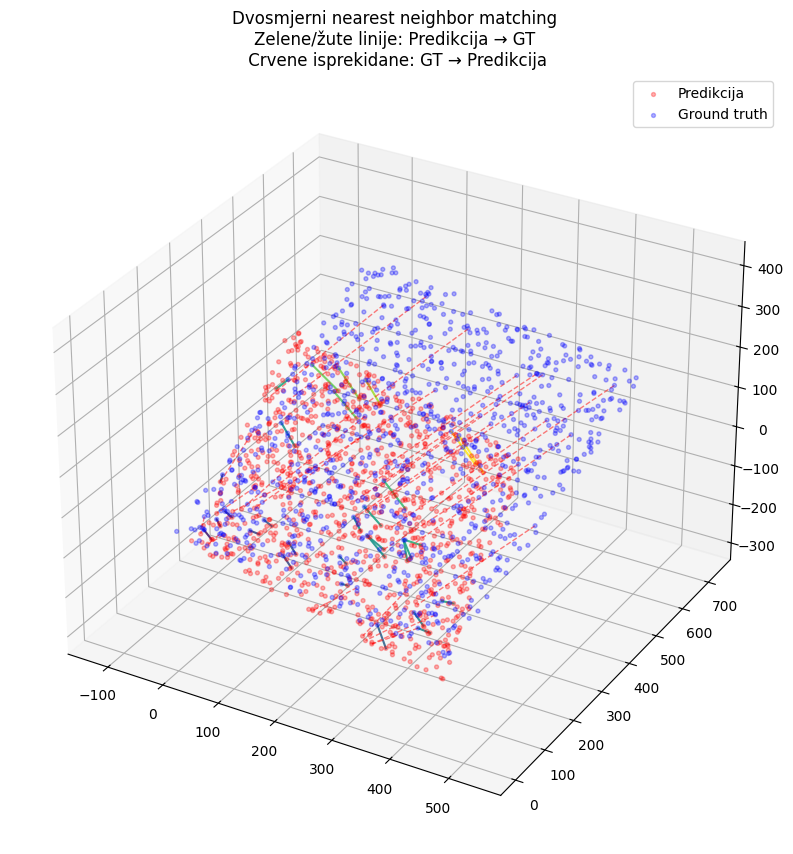

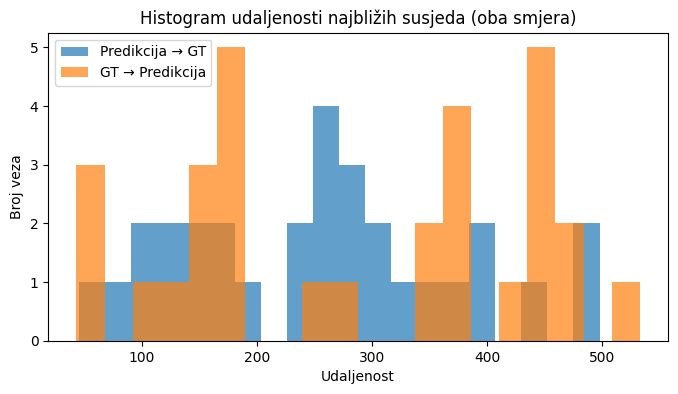

Predikcija → GT: prosječna udaljenost = 253.29, max = 497.46
GT → Predikcija: prosječna udaljenost = 287.13, max = 532.62


In [41]:
# EMD (Earth Mover's Distance, Wasserstein Distance)
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

N = 30

tree_gt = cKDTree(tgt_np)
idx_pred = np.random.choice(len(src_pred_np), N, replace=False)
pred_points = src_pred_np[idx_pred]
dists_pred_to_gt, indices_pred_to_gt = tree_gt.query(pred_points)
matched_gt = tgt_np[indices_pred_to_gt]

tree_pred = cKDTree(src_pred_np)
idx_gt = np.random.choice(len(tgt_np), N, replace=False)
gt_points = tgt_np[idx_gt]
dists_gt_to_pred, indices_gt_to_pred = tree_pred.query(gt_points)
matched_pred = src_pred_np[indices_gt_to_pred]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(src_pred_np[:,0], src_pred_np[:,1], src_pred_np[:,2], s=8, c='r', label='Predikcija', alpha=0.3)
ax.scatter(tgt_np[:,0], tgt_np[:,1], tgt_np[:,2], s=8, c='b', label='Ground truth', alpha=0.3)

for p, g, d in zip(pred_points, matched_gt, dists_pred_to_gt):
    color = plt.cm.viridis(min(d/np.max(dists_pred_to_gt),1))[:3]
    ax.plot([p[0], g[0]], [p[1], g[1]], [p[2], g[2]], color=color, linewidth=1.5, alpha=0.9)

for g, p, d in zip(gt_points, matched_pred, dists_gt_to_pred):
    ax.plot([g[0], p[0]], [g[1], p[1]], [g[2], p[2]], color='red', linewidth=1, alpha=0.5, linestyle='dashed')

ax.set_title("Dvosmjerni nearest neighbor matching\nZelene/žute linije: Predikcija → GT\n Crvene isprekidane: GT → Predikcija")
ax.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(dists_pred_to_gt, bins=20, alpha=0.7, label='Predikcija → GT')
plt.hist(dists_gt_to_pred, bins=20, alpha=0.7, label='GT → Predikcija')
plt.title("Histogram udaljenosti najbližih susjeda (oba smjera)")
plt.xlabel("Udaljenost")
plt.ylabel("Broj veza")
plt.legend()
plt.show()


print(f"Predikcija → GT: prosječna udaljenost = {np.mean(dists_pred_to_gt):.2f}, max = {np.max(dists_pred_to_gt):.2f}")
print(f"GT → Predikcija: prosječna udaljenost = {np.mean(dists_gt_to_pred):.2f}, max = {np.max(dists_gt_to_pred):.2f}")